In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

df = pd.read_csv("diabetes.csv")
df.sample()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
10,4,110,92,0,0,37.6,0.191,30,0


In [3]:
def prepare_data(df: pd.DataFrame):
    X, y = df.drop(columns=["Outcome"]), df["Outcome"]
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)
    y_array = y.values
    x_train, x_val, y_train, y_val = train_test_split(x_scaled, y_array,test_size=0.2,random_state=42,stratify=y_array)
    return x_train, x_val, y_train, y_val, scaler

In [4]:
X_train, X_val, y_train, y_val, scaler = prepare_data(df)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((614, 8), (154, 8), (614,), (154,))

In [5]:
class DiabetesDataset(Dataset):
    def __init__(self,x,y):
        super().__init__()
        
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1,1)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [6]:
train_ds = DiabetesDataset(X_train, y_train)
val_ds = DiabetesDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

len(train_ds), len(val_ds)

(614, 154)

In [13]:
def build_model(input_dim: int) -> nn.Module:
    model = nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid(),
    )
    return model

In [14]:
input_dim = X_train.shape[1]
model = build_model(input_dim)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

Sequential(
  (0): Linear(in_features=8, out_features=32, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=1, bias=True)
  (6): Sigmoid()
)

In [15]:
def train_one_epoch(model: nn.Module,
                    train_loader: DataLoader,
                    criterion,
                    optimizer) -> float:
    
    model.train()
    losses = []
    batches = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        batches += 1
    return sum(losses) / batches

In [16]:
def evaluate(model: nn.Module, val_loader: DataLoader) -> float:
    model.eval()
    all_true_labels = []
    all_predicted_labels = []
    
    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs = model(inputs)
            predictions = (outputs >= 0.5).float()
            all_predicted_labels.extend(predictions.numpy().flatten())
            all_true_labels.extend(labels.numpy().flatten())
    
    return float(accuracy_score(all_true_labels,all_predicted_labels))

In [17]:
epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_acc = evaluate(model, val_loader)
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f}")

Epoch 1/10 | Train loss: 0.6685 | Val acc: 0.6623
Epoch 2/10 | Train loss: 0.6547 | Val acc: 0.6623
Epoch 3/10 | Train loss: 0.6395 | Val acc: 0.6753
Epoch 4/10 | Train loss: 0.6204 | Val acc: 0.6753
Epoch 5/10 | Train loss: 0.6026 | Val acc: 0.6753
Epoch 6/10 | Train loss: 0.5798 | Val acc: 0.7078
Epoch 7/10 | Train loss: 0.5632 | Val acc: 0.7143
Epoch 8/10 | Train loss: 0.5392 | Val acc: 0.7143
Epoch 9/10 | Train loss: 0.5209 | Val acc: 0.7273
Epoch 10/10 | Train loss: 0.5124 | Val acc: 0.7273


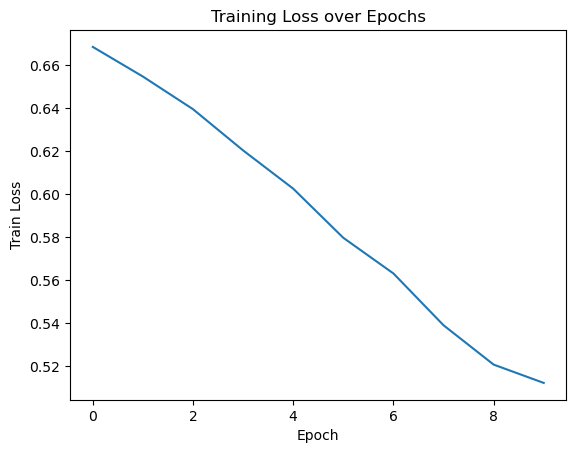

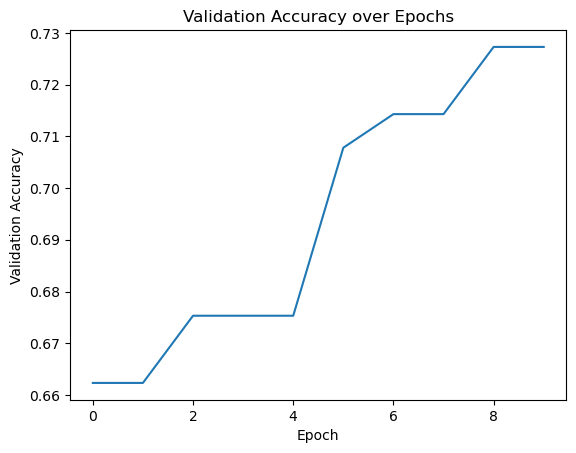

In [18]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss over Epochs")
plt.show()

plt.plot(val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.show()